# Assignment 11: Model Selection, Regularized regression and final practice
## Learning goals 
This homework includes some repeated task and variations on model fitting, and model comparison, which should prepare you optimally for the final. 
The homework also introduces z-standardization and regularized (L2) regression. 
Try to solve the task in the homework independently, and prepare a cheat-sheet and a file with useful functions, such that you can complete this homework in 3 hrs or less. 

## Data set 
The file kaiser.csv contains a subset of data from the Child Health and Development Studies, which investigate a range of topics. One study considered all pregnancies between 1960 and 1967 among women in the Kaiser Foundation Health Plan in the San Francisco East Bay area. Here, we look at the predictor of birth weight of babies, measured in pounds, as well as the occurrence of complications in the first 3 month. 

The data frame stored in kaiser.csv contains the variables: 
- age:          Age of the mom at time of birth
- smoke:        Is the mom a smoker / non-smoker? 
- hospital:     Which hospital was the birth at? Oakland, SanFrancisco, WalnutCreek, SanJose, and Richmond.
- gestation:    Gestation period (length of pregnancy) [days]
- parity:       1: child the first born 0: Child has older siblings 
- weight:       Weight of the baby [pounds].  
- complication: Was there a complication within the first 3 month of pregnancy (0: No 1:Yes) 

## Preliminaries
Set up the environment by importing pandas, seaborn, numpy, scipy.optimize and matplotlib. 
Then add your multiple regression functions (multRegPredict,multRegLossRSS, multRegFit) from the last homeworks. 

To make it easier - we have done these things already! 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as so
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
def multRegPredict(b,D,xname):
    """Prediction function for multiple regression

    Args:
        b (nd.array): Array of regression coefficients - first is intercept
        D (pd.DataFrame): Pandas data frame with explanatory variables
        xname (list): List of strings with names of explanatory variables

    Returns:
        yp (nd.array): Predicted y - values
    """
    yp=np.ones(len(D.index))*b[0]        # Intercept
    for i in range(len(xname)):
        yp=yp+D[xname[i]]*b[i+1]         # Add each regression value
    return yp

def multRegLossRSS(b,D,y,xname):
    """Loss function for OLS multiple regression

    Args:
        b (nd.array): Array of regression coefficients - first is intercept
        D (pd.DataFrame): Pandas data frame with explanatory variables
        y (ndarray): Dependent variable
        xname (list): List of strings with names of explanatory variables

    Returns:
        rss: Current loss
        grad: gradient of loss function in respect to parameters
    """
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)
    return (rss,grad)

def multRegFit(D,y,xname=[],figure=0,b0=[]):
    """Fits a multiple regression loss function

    Args:
        D (pd.DataFrame): Pandas data frame with explanatory variables
        y (ndarray): Dependent variable
        xname (list): List of strings with names of explanatory variables
        figure (int): Plot figure? Defaults to 0.
        b0 (np.ndarray). Initial guess for the parameter vector

    Returns:
        R2: Fitted R2 value
        b: Fitted
    """
    k=len(xname)+1
    if (len(b0)!=k):
        b0=np.zeros((k,))
    RES = so.minimize(multRegLossRSS,b0,args=(D,y,xname),jac=True)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS
    if (k==2 and figure==1):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(D[xname[0]],y)
        xRange=[min(D[xname[0]]),max(D[xname[0]])]
        xp=np.arange(xRange[0],xRange[1],(xRange[1]-xRange[0])/50)
        yp=b[0]+b[1]*xp
        ax.plot(xp,yp,'r-')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return (R2,b)

## Task 1: Multiple regression with discrete variables ( / 30 pts)
### Question 1.1 ( / 10pt)
Create a dummy variable for Smoker / Non-smoker. Set the value for “Smoker” to 1 and for “Non-smoker” to 0. Estimate a regression model with the dummy variable as a regressor *and birth weight as the response variable.* Use the RSS as the loss function. 

Report the value of the intercept and slope. 

Written answer: What does the intercept and slope value indicate? 


In [3]:
D = pd.read_csv('kaiser.csv')

In [4]:
D['smokeDummy'] = np.double(D['smoke'] == 'smoker')

The intercept is 7.69
The slope is -1.21 


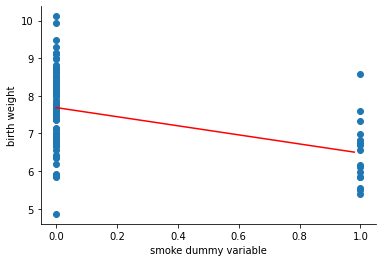

In [5]:
r2, b = multRegFit(D,D['weight'],['smokeDummy'],figure=1,b0=[])
plt.xlabel('smoke dummy variable')
plt.ylabel('birth weight')
print(f'The intercept is {b[0]:.2f}')
print(f'The slope is {b[1]:.2f} ' )

*Figure 1*. Shows the scatter plot of birth weight of babies with smoking mothers (1) and non-smoking moms (0). The red line is the regression line.

> b0 (the intercept) is the mean of the non-smoking group (y = b[0] + b[1] * 0) and b[1] is the difference between the means of smokers and non-smokers (y = b[0] + b[1] * 1). Since b[1] is a negative value, the mean birth weight of babies of smoker group is lower than the mean of the non-smoker group.

### Question 1.2 ( / 8pt)
Make a boxplot of hospital on the x-axis and birthweight on the y-axis (see HW2 for an example). Which hospital has the lowest overall birth weight?  

<Axes: xlabel='hospital', ylabel='weight'>

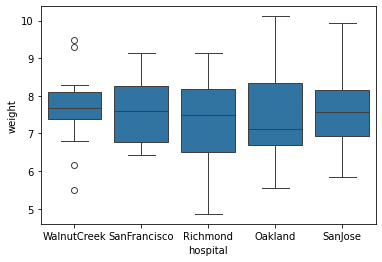

In [6]:
sns.boxplot(x=D.hospital,y=D.weight)

*Figure 2*. Boxplot of birth weight of babies grouped by the hospital

In [7]:
# Calucate the mean weight for each hospital
D.groupby('hospital').mean()['weight']

hospital
Oakland         7.441426
Richmond        7.313273
SanFrancisco    7.667122
SanJose         7.544500
WalnutCreek     7.645780
Name: weight, dtype: float64

Richmond has the lowest average birth weight. 

### Question 1.3  ( / 12pt)
Create a set of 4 dummy variables that together code the hospital. Set Walnut Creek to be your comparison group. Run a multiple regression model with the 4 dummy variables as explanatory variables. Report the interecept and slope values. What do the intercept and slope values mean? 

In [8]:
D['hospOAK'] = np.double(D.hospital=='Oakland')
D['hospSFO'] = np.double(D.hospital=='SanFrancisco')
D['hospSJO'] = np.double(D.hospital=='SanJose')
D['hospRIM'] = np.double(D.hospital=='Richmond')

In [9]:
r2,b=multRegFit(D,D.weight,['hospOAK','hospSFO','hospSJO','hospRIM'])
print(f"B:{b[0]:3.3f}")
print(f"B:{b[1]:3.3f}")
print(f"B:{b[2]:3.3f}")
print(f"B:{b[3]:3.3f}")
print(f"B:{b[4]:3.3f}")

B:7.646
B:-0.204
B:0.021
B:-0.101
B:-0.333


> The incept is 7.429, which is the average weight for WalnutCreek<br> 
The slope for Oakland is -0.204, which means that the birth weight of babies in Oakland is 0.2 pounds lower than in WC <br>
The slope for SFO is 0.021, which means that the birth weight of babies in SF is 0.021 pounds higher than in WC<br>
The slope for SJO is -0.101, which means that the birth weight of babies in San Jose is 0.101 lower than in WC<br>
The slope for Richmond is -0.33, which means that the birth weight of babies in Richmond is 0.33 pounds lower than in WC<br>

## Task 2: Model selection for multiple regression  ( / 35 pts)
### Question 2.1 ( / 20 pts)
Write a version of the crossvalidation function that does K-fold crossvalidation and works specifically with multRegFit as the fitting function. 

KfoldCVmultReg(D,y,xname,K=20,fitfcn=multRegFit,param={},predictfcn=multRegPredict):
- D: Data Frame with explanatory variables  
- y: response variable 
- xname: List of explanatory variables
- K: Number of crossvalidation folds

For dividing the data up in K pieces, you can use the following trick to assign a partition index to each of the data-points:
```
#N = number of data points 
#K = number of test sets (folds)
ind = np.arange(N)
ind = np.floor(ind/N*K)
```


The code should compute and return the predictive (crossvalidated) $R^2$ (R2cv) and the fitted $R^2$ (R2). 
It should use the entries in the Dictionary to pass them to the function using `fitfcn(D,y,xname,**param)`
Run 20-fold crossvalidation on the multiple regression model, with birth weight as the response variable and 

- age of the mother 
- smoker (dummy coded) 
- birth occurred in Oakland? 
- gestation 

as explanatory variables. 
Report R2cv and R2. 

In [10]:
def KfoldCVmultReg(D,y,xname,K=20):
    """K-fold Crossvalidation for multiple regression"""
    N = len(y) #Number of observations
    yp= np.zeros(N)

    # Make an index vector with K folds
    ind = np.arange(N)
    ind = np.floor(ind/N*K)

    # Get overall model fit
    R2,b_all=multRegFit(D,y,xname)

    # Loop over the crossvalidation folds
    for i in range(K):
        r,b=multRegFit(D[ind!=i],y[ind!=i],xname,b0=b_all)
        yp[ind==i]=multRegPredict(b,D[ind==i],xname)

    # Calculate crossvalidated model fit
    TSS  = sum((y-y.mean())**2)
    RSScv = sum((y-yp)**2)
    R2cv = 1-RSScv/TSS
    return R2cv,R2

In [11]:
R2cv,R2 = KfoldCVmultReg(D,D.weight,['age','smokeDummy','gestation','parity'])
print(f"Fitted R2:{R2:.4f}")
print(f"Crossvalidated R2:{R2cv:.4f}")

Fitted R2:0.3503
Crossvalidated R2:0.2882


> R2 is 0.3503, and cv R2 is 0.2882. So overall, we are able to predict 28.82% of the variance 

### Question 2.2 ( / 15 pts)
Using the R2cv from the 20-fold crossvalidation, determine the best predictive model for birthweight using the following candidate variables 

- age of mom
- smoker (dummy coded) 
- gestation 
- parity 

Start with the R2cv for the full model (Question 2.1)and use **backwards** step-wise regression to find the best model (the model that increases R2cv the most). Show all steps of your selection procedure. Report the formula of your best model. 

In [12]:
# Dropping Age
R2cv,R2 = KfoldCVmultReg(D,D.weight,['smokeDummy','gestation','parity'])
print(f"Fitted R2:{R2:.4f}")
print(f"Crossvalidated R2:{R2cv:.4f}")

Fitted R2:0.3423
Crossvalidated R2:0.2950


In [13]:
# Dropping Smoke Dummy
R2cv,R2 = KfoldCVmultReg(D,D.weight,['age','gestation','parity'])
print(f"Fitted R2:{R2:.4f}")
print(f"Crossvalidated R2:{R2cv:.4f}")

Fitted R2:0.2244
Crossvalidated R2:0.1626


In [14]:
# Dropping gestation
R2cv,R2 = KfoldCVmultReg(D,D.weight,['age','smokeDummy','parity'])
print(f"Fitted R2:{R2:.4f}")
print(f"Crossvalidated R2:{R2cv:.4f}")


Fitted R2:0.1917
Crossvalidated R2:0.1282


In [15]:
# Dropping parity
R2cv,R2 = KfoldCVmultReg(D,D.weight,['age','smokeDummy','gestation'])
print(f"Fitted R2:{R2:.4f}")
print(f"Crossvalidated R2:{R2cv:.4f}")

Fitted R2:0.3503
Crossvalidated R2:0.2936


> The R2cv increases most when dropping age as an explanatory variables. So we drop age and proceed with trying to drop another variable. 

In [16]:
# Dropping Smoke Dummy
R2cv,R2 = KfoldCVmultReg(D,D.weight,['gestation','parity'])
print(f"Fitted R2:{R2:.4f}")
print(f"Crossvalidated R2:{R2cv:.4f}")

Fitted R2:0.2216
Crossvalidated R2:0.1757


In [17]:
# Dropping gestation
R2cv,R2 = KfoldCVmultReg(D,D.weight,['age','parity'])
print(f"Fitted R2:{R2:.4f}")
print(f"Crossvalidated R2:{R2cv:.4f}")

Fitted R2:0.0067
Crossvalidated R2:-0.0606


In [18]:
# Dropping parity
R2cv,R2 = KfoldCVmultReg(D,D.weight,['smokeDummy','gestation'])
print(f"Fitted R2:{R2:.4f}")
print(f"Crossvalidated R2:{R2cv:.4f}")

Fitted R2:0.3403
Crossvalidated R2:0.3014


Dropping Parity improves the cross-validated R2 most. 
Dropping either of these terms now decreases R2cv quite dramatically - so 

weight = b_0 + b_1 * smokeDummy + b_2 * gestation 

is our best model

## Task 3: Implement regularized regression to build a better predictive model (/35pts)
In this task you will implement regularized regression to try to build a better predictive model for the birthweight of data. 
Like in Task 2, we will consider the following explanatory variables:

- age of the mother 
- smoker (dummy coded) 
- birth occurred in Oakland? 
- gestation 

### Question 3.1: Z-standardize the regressors (/8pts)
Write a function `zstandardize`, which takes as an input a pandas series or ndarray 
and returns a z-standardized version of the data 

Use the function to z-standardize the columns age,gestation,parity, and smokeDummy. 

Create new columns in the data frame called ageZ,gestationZ,parityZ, and smokeDummyZ.

Check that the mean of the new variables in very close to and the std very close to 1.  

In [19]:
# Z-standardize the data
def zstandardize(d):
    d = (d-d.mean())/d.std()
    return d

D['ageZ'] = zstandardize(D.age)
D['gestationZ'] = zstandardize(D.gestation)
D['parityZ'] = zstandardize(D.parity)
D['smokeDummyZ'] = zstandardize(D.smokeDummy)

print(f'Mean: {D.ageZ.mean()}')
print(f'Std: {D.ageZ.std()}')



Mean: 7.915890165577366e-16
Std: 1.0


### Question 3.2 Implement Ridge regression (L2 regularized regression) (/17pts)

To implement ridge regression you need to modify two functions, the most important being the loss function. 
Make a copy of the function `multRegLossRSS` from assigment 10. 
Rename it to `ridgeLoss`. Give the function an additional input parameter, namely alpha. Give this a default value of 1.0. 

Change the loss and the gradient to take into account the regularization. 

**Note that we are not regularizing the intercept regressor (b0)**

Overall the function should take the following input arguments:

    Args:
        b (nd.array): Array of regression coefficients - first is intercept 
        D (pd.DataFrame): Pandas data frame with explanatory variables
        y (ndarray): Dependent variable 
        xname (list): List of strings with names of explanatory variables
        alpha (float): Regularization parameter 

    Returns:
        loss: Current loss
        grad: gradient of loss function in respect to parameters  

Then make a copy of `multRegFit` from the last homework and rename it to `ridgeFit`. 
Again, you need to add an additional input parameter (alpha) to the function. 
Alpha needs to be passed to your loss function (`ridgeLoss`) when you call so.minimize: 

`so.minimize(ridgeLoss,b0,args=(D,y,xname,alpha),jac=True)`

You need to take care when you calculate R2 of the fit - Since ridgeLoss does not return the 
residual-sum-of-squares, you need to use the appropriate function to calculate the RSS.

To test your function:
* Use it to fit a model that explains weight with the explanatory variables `['ageZ','smokeDummyZ','gestationZ','parityZ']`. Note: use the zstandardized version of the variables.  
* Do the fit setting `alpha=0` and `alpha=8`, and report both R2 and the regression coefficients (b)
* Compare the R2 between the two settings of alpha. Also compare to the one found for normal multiple regression (Question 2.1). What do you see and why?
* Compare the regression weights (b) between the two settings of alpha. which regression weights changed and why? 


In [20]:
def ridgeLoss(b,D,y,xname,alpha=1.0):
    """Loss function for Ridge regression

    Args:
        b (nd.array): Array of regression coefficients - first is intercept
        D (pd.DataFrame): Pandas data frame with explanatory variables
        y (ndarray): Dependent variable
        xname (list): List of strings with names of explanatory variables
        alpha (float): Ridge regression parameter
    Returns:
        rss: Current loss
        grad: gradient of loss function in respect to parameters
    """
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)+alpha*sum(b[1:]**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)+2*alpha*b[i+1]
    return (rss,grad)

def ridgeFit(D,y,xname,figure=0,b0=[],alpha=1.0):
    """Fits a multiple regression loss function

    Args:
        D (pd.DataFrame): Pandas data frame with explanatory variables
        y (ndarray): Dependent variable
        xname (list): List of strings with names of explanatory variables
        figure (int): Plot figure? Defaults to 0.
        b0 (np.ndarray). Initial guess for the parameter vector
        alpha (float): Ridge regression parameter
    Returns:
        R2: Fitted R2 value
        b: Fitted
    """
    k=len(xname)+1
    if (len(b0)!=k):
        b0=np.zeros((k,))
    RES = so.minimize(ridgeLoss,b0,args=(D,y,xname,alpha),jac=True)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS
    if (k==2 and figure==1):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(D[xname[0]],y)
        xRange=[min(D[xname[0]]),max(D[xname[0]])]
        xp=np.arange(xRange[0],xRange[1],(xRange[1]-xRange[0])/50)
        yp=b[0]+b[1]*xp
        ax.plot(xp,yp,'r-')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return (R2,b)

In [21]:
R2_0,b_0 = ridgeFit(D,D.weight,['ageZ','smokeDummyZ','gestationZ','parityZ'],alpha=0.0)
R2_1,b_1 = ridgeFit(D,D.weight,['ageZ','smokeDummyZ','gestationZ','parityZ'],alpha=8.0)

print('alpha=0')
print(f'R2: {R2_0:.4f}')

print('alpha=8')
print(f'R2: {R2_1:.4f}')


alpha=0
R2: 0.3503
alpha=8
R2: 0.3488


The fitted R2 value reduces when we add regularization to the model. The R2 for `alpha=0` is identical to normal regression - because we set the regularization to zero, so it has no effect. *BTW: this is also a good test if your functions work correctly!*

In [22]:
print('alpha=0')
print(b_0.round(3))
print('alpha=8')
print(b_1.round(3))


alpha=0
[ 7.495e+00 -1.040e-01 -3.830e-01  4.340e-01  4.000e-03]
alpha=8
[ 7.495e+00 -9.400e-02 -3.580e-01  4.050e-01  3.000e-03]


The intercept regressor (`b[0]`) did not change, as it was not regularized. However, all other regression coefficients are now closer to zero. 

### Question 3.3: Crossvalidate Ridge regression (10pts)
Copy your function `KfoldCVmultReg` from Question 2.1, rename it to `KfoldCVridge`, and modify it to work with Ridge regression. 
That means it needs to take an additional input parameter `alpha` that it passes on to the fitting function. 

To calculate the R2 and R2cv for the model of `weight` using the explanatory variables `['ageZ','smokeDummyZ','gestationZ','parityZ']`. Like in question 3.2, use the standardized versions of the variables and try both the setting `alpha=0` and `alpha=8`. 

How to the R2 and R2cv values compare between the two settings of alpha? Do you get better predictive performance than the reduced model that you found using feature selection (Question 2.2)?


*Note: If you want, play a bit with the regularization parameter to see if you can find a better setting. What happens when you make `alpha` very large (i.e. 1000)? (this is optional, but educational)*

In [23]:
def KfoldCVridge(D,y,xname,K=20,alpha=1.0):
    """K-fold Crossvalidation for multiple regression"""
    N = len(y) #Number of observations
    yp= np.zeros(N)

    # Make an index vector with K folds
    ind = np.arange(N)
    ind = np.floor(ind/N*K)

    # Get overall model fit
    R2,b_all=ridgeFit(D,y,xname,alpha=alpha)

    # Loop over the crossvalidation folds
    for i in range(K):
        r,b=ridgeFit(D[ind!=i],y[ind!=i],xname,b0=b_all,alpha=alpha)
        yp[ind==i]=multRegPredict(b,D[ind==i],xname)

    # Calculate crossvalidated model fit
    TSS  = sum((y-y.mean())**2)
    RSScv = sum((y-yp)**2)
    R2cv = 1-RSScv/TSS
    return R2cv,R2

In [24]:
R2cv,R2 = KfoldCVridge(D,D.weight,['ageZ','smokeDummyZ','gestationZ','parityZ'],alpha=0)
print(f"Fitted R2:{R2:.4f}")
print(f"Crossvalidated R2:{R2cv:.4f}")

Fitted R2:0.3503
Crossvalidated R2:0.2882


In [25]:
R2cv,R2 = KfoldCVridge(D,D.weight,['ageZ','smokeDummyZ','gestationZ'],alpha=8)
print(f"Fitted R2:{R2:.4f}")
print(f"Crossvalidated R2:{R2cv:.4f}")

Fitted R2:0.3487
Crossvalidated R2:0.2950


As stated in Question 3.2. the fitted R2 becomes smaller for higher regularization parameter, because we do not minimize RSS anymore. 

In contrast, cross-validated R2 increases when regularizing the model. However the regularized model is not quite as good as the one that we found in question 2.2 using backwards stepwise regression. 
 

## Task 4: Use logistic regression to predict complications 
In this task you will create and test a logistic regression model that predicts the presence of a complication in the first three month (0: no complication, 1: complication). 

** Task 4 of the Homework does not have to be handed in and will not be graded! It is only added here to provide additional preparation and practice for you for the final. So if you are short on time, leave these questions open and solve them when you practice for the final.**

### Question 4.1: Improving your logistic regression model code
Improve your code for logisitic regression in two ways: 

1. prevent log(0) errors by making sure that your predicted value never is smaller than 1e-20 or larger than 1-1e-20. (tip you can use the numpy function `clip`)

2. Let logisticRegFit take an additional input parameter, telling it whether it should plot a figure or not (figure=1) 

3. Let logisticRegFit take an additional input parameter, specifying the starting value for the parameters (b_init=[]). If b_init is empty, the function should start with a vector off all zeros. 

In [26]:
def logisticRegPredict(b,D,xname):
    yp=np.ones(len(D.index))*b[0]       # Start out with the intercept
    for i in range(len(xname)):
        yp=yp+D[xname[i]]*b[i+1]        # Add the prediction of each regressor seperately
    p = np.exp(yp)/(1+np.exp(yp))
    p = p.clip(1e-12,1-(1e-12))
    return p

def logisticRegLoss(b,D,y,xname):
    p = logisticRegPredict(b,D,xname)
    cost = -y*np.log(p)-(1-y)*np.log(1-p)
    N=len(xname)
    grad=np.zeros(N+1)
    res = y-p
    grad[0]=-sum(res)
    for i in range(N):
        grad[i+1]=-np.sum(D[xname[i]]*res)         # Add each regressor
    return (cost.sum(),grad)

def logisticRegFit(D,y,xname,figure=0,b_init=[]):
    k=len(xname)+1
    if (len(b_init)!=k):
        b_init=np.zeros(k)
    RES = so.minimize(logisticRegLoss,b_init,args=(D,y,xname),jac=True)
    b = RES.x
    ll = -RES.fun # Negative function value is the log likelihood
    p = logisticRegPredict(b,D,xname)
    if (k==2 & figure==1):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(D[xname[0]],y)
        xRange=[min(D[xname[0]]),max(D[xname[0]])]
        xp=np.arange(xRange[0],xRange[1],(xRange[1]-xRange[0])/50)
        yp=b[0]+b[1]*xp
        pp=np.exp(yp)/(1+np.exp(yp))
        ax.plot(xp,pp,'r-')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return (ll,b)

### Question 4.2: Crossvalidation of logistic models
Modify the KfoldCVmultReg function to make it work for logistic regression. As before, use K-fold crossvalidation. The main changes are that 
- you need to use logisticRegFit and logisticRegPredict as fitfcn and predictfcn respectively. 
- To save time, initialize each optimization with from the parameters that you found on the entire data by setting `b_init` 
- instead of the crossvalidated R2, your function should return the crossvalidated log-likelihood and non-crossvalidated log-likelihood. 

Using your function, calculate the the difference in crossvalidated log-likelihood for the model that predicts complications with an intercept only (b0) and a model that predicts complications with an intercept and smokeDummy. 
From the difference, report the Bayes-Factor between the two models. What do you conclude? 

In [27]:
def KfoldCVlogisticReg(D,y,xname,K=20,fitfcn=logisticRegFit,predictfcn=logisticRegPredict):
    N = len(y) #Number of observations
    yp= np.zeros(N)
    ind = np.arange(N)
    ind = np.floor(ind/N*K)

    # Get overall model fit
    LL,b_all=fitfcn(D,y,xname,figure=0)

    # Loop over the crossvalidation folds
    for i in range(K):
        r,b=fitfcn(D[ind!=i],y[ind!=i],xname,b_init=b_all,figure=0)
        yp[ind==i]=predictfcn(b,D[ind==i],xname)
    LLcv = sum(y*np.log(yp)+(1-y)*np.log(1-yp))
    return LLcv,LL

In [28]:
llcv0,ll0=KfoldCVlogisticReg(D,D.complication,[])
llcv1,ll1=KfoldCVlogisticReg(D,D.complication,['smokeDummy'])
print(f'Log-likelihood difference between Smoke and intercept model:{llcv1-llcv0:.4f}')
print(f'Bayes Factor: {np.exp(llcv1-llcv0):.3f}')

Log-likelihood difference between Smoke and intercept model:1.8248
Bayes Factor: 6.201


> There is positive evidence that smoking leads to increased chance of complications in the first 3 month.  

### Question 4.3:
Compare the model that uses only intercept, smoking as explanatory variable to one that uses: 

 * intercept, smoking, weight 
 * intercept, smoking, age 
 * intercept, smoking, weight, age 
 
Report the cross-validated Log-likelihood for each model. Which one is the best model? 

In [29]:
llcv2,ll2=KfoldCVlogisticReg(D,D.complication,['smokeDummy','weight'])
print(f'Adding weight to baseline mode: {llcv2-llcv1:.3f}')

Adding weight to baseline mode: 1.751


In [30]:
llcv3,ll3=KfoldCVlogisticReg(D,D.complication,['smokeDummy','age'])
print(f'Adding age to baseline mode: {llcv3-llcv1:.3f}')

Adding age to baseline mode: -0.976


In [31]:
llcv4,ll4=KfoldCVlogisticReg(D,D.complication,['smokeDummy','weight','age'])
print(f'Adding age and weight to baseline mode: {llcv4-llcv1:.3f}')

Adding age and weight to baseline mode: 0.699


> According to the crossvalidated likelihood, the model with smoking, weight is the best model. However, there is no positive evidence (in terms of a Bayes factor) that adding age into the model increases the prediction. The most complex model (smoking, weight, age) is not better than the model with only smoking and weight. 

### Question 4.4 : 
In the model (['smokeDummy','weight']), how do each of the explanatory variables contribute to the chance of complication? That is, for each variable, would an increase an the variable lead to an increased or decreased probability of a complication? 

What reduction in birth weight causes the same amount of risk of complication as having a smoking mother?  

In [32]:
ll,b=logisticRegFit(D,D.complication,['smokeDummy','weight'])
print(f'Intercept: {b[0]:.3f}')
print(f'Smoke: {b[1]:.3f}')
print(f'Weight: {b[2]:.3f}')

Intercept: 3.764
Smoke: 0.611
Weight: -0.719


In [33]:
print(f'Ratio of slopes smoking / pounds: {b[1]/b[2]:.3f}')

Ratio of slopes smoking / pounds: -0.850


> Smoking increases the chances of complication. Lower weight also increases the chances of complications. Smoking adds about as much risk as a lower birthweight of 0.85 pounds.